# PARTE 3: Modelos predictivos con python

### 1.Cargamos los datos

In [117]:
#Carga de paquetes que iremos usando
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


dtype_dict = {
    1: float,
    23: str,
    24: str,
    25: str,
    28: str,
    29: str,
    30: str,
    38: str,
    39: str,
    40: str,
}
prestamos=pd.read_csv('./Washington_State_HDMA.csv',sep=";",dtype=dtype_dict,decimal=",",na_values=["N/A", "unknown", "?", 'NaN'])

#### Limpiamos los datos

In [119]:
prestamos.dropna(subset=["Ingreso_solicit"], axis=0, inplace=True)
prestamos.dropna(subset=["Tract"], axis=0, inplace=True)
prestamos.dropna(subset=["msamd_name"], axis=0, inplace=True)
prestamos.dropna(subset=["nro_viv_ocupadas"], axis=0, inplace=True)

In [121]:
prestamos['rate_spread']=prestamos['rate_spread'].fillna(1)
prestamos['edit_status_name']=prestamos['edit_status_name'].fillna('ok')
columnas_object = prestamos.select_dtypes(include=["object"]).columns
prestamos[columnas_object] = prestamos[columnas_object].astype("category")
prestamos['Accion_tomada'] = np.where(prestamos['Accion_tomada'] == 'Aprobado', 1, 0)

In [93]:
#prestamos.dtypes
#prestamos.info()
#prestamos.describe()

### 2.Quitamos las variables que no aportan nada

In [123]:
prestamos2=prestamos[[
  "Tract"
  , "rate_spread"
  , "population"                    
  , "minorias"           
  , "nro_viv_ocupadas"
  , "nro_unid_residenciales" 
  , "loan_amount_000s"              
  , "Ingreso_medio_fam"      
  , "Ingreso_solicit"         
  #, "nro_cliente"               
  , "tipo_comprador"           
  , "tipo_propiedad"            
  , "preaprovacion"              
  , "tipo_ocupacion"          
  , "msamd_name"                    
  , "loan_type_name"                
  , "proposito"             
  , "gravamen"              
  , "hoepa"             
  , "edit_status_name"              
  #, "denegacion2"          
  #, "denegacion1"          
  , "condado"                   
  , "sexo_coapp"         
  , "Raza_coapp"      
  , "etnia_coapp"   
  , "census_tract_number"           
  , "Sexo"            
  , "Raza"         
  , "Etnia"      
  , "agency_abbr"
  , "Accion_tomada"]]
#prestamos2.info()
#prestamos2.dtypes

#### Codificamos las variables categóricas

In [125]:
prestamos2=pd.get_dummies(prestamos2, columns=["tipo_comprador", "tipo_propiedad",'preaprovacion','tipo_ocupacion','msamd_name','loan_type_name',
                                         'proposito','gravamen','hoepa','edit_status_name','condado','sexo_coapp','Raza_coapp','etnia_coapp','Sexo',
                                         'Raza','Etnia','agency_abbr'])

In [127]:
prestamos2.columns = prestamos2.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
prestamos2.columns = prestamos2.columns.str.replace(' ', '_')

## 3.Modelos


Dividimos el dataset en los conjuntos train, validación y test.

In [129]:
X=prestamos2.drop("Accion_tomada", axis=1)
y = prestamos2["Accion_tomada"] 

In [131]:
from sklearn.model_selection import train_test_split

pct_val = 0.20
pct_test = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=pct_test, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=pct_val/(1-pct_test), random_state=42)

### 3.1.Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

params_grid = {"n_estimators": [25,50, 100, 150],
               "max_depth": [None, 10, 20]}
best_score = 0
best_params = {}
for n_estimators in params_grid["n_estimators"]:
    for max_depth in params_grid["max_depth"]:
        rf=RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            bootstrap=True,
            oob_score=False,
            n_jobs=multiprocessing.cpu_count()
            )
        rf.fit(X_train, y_train)

    y_val_pred = rf.predict(X_val)
    score = precision_score(y_val, y_val_pred)
    if score > best_score:
        best_score = score
        best_params = {"n_estimators": n_estimators, "max_depth": max_depth}
                      


In [35]:
print(best_score)
print(best_params)

0.9487581588539459
{'n_estimators': 100, 'max_depth': 20}


In [37]:
rf_final=RandomForestClassifier(
        n_estimators=100,
        max_depth=20,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        bootstrap=True,
        oob_score=False,
        n_jobs=multiprocessing.cpu_count()
    )
rf_final.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=20,
                       n_jobs=8)

In [39]:
y_train_hat = rf_final.predict(X_train)
y_val_hat = rf_final.predict(X_val)

precision_train = precision_score(y_train, y_train_hat)
precision_val = precision_score(y_val, y_val_hat)

print("Precision train:\n",precision_train)
print("Precision val:\n", precision_val)

Precision train:
 0.9547937623333493
Precision val:
 0.9466728495246928


In [41]:
y_test_hat = rf_final.predict(X_test)
precision_test = precision_score(y_test, y_test_hat)
print("Precision test:\n",precision_test)

Precision test:
 0.9466655432447234


### 3.2 XGBoost

In [17]:
import xgboost as xgb
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

params_grid = {
    "max_depth": [3, 5],          # Profundidad reducida para eficiencia
    "learning_rate": [0.01, 0.05, 0.1],  # Rango típico para tasa de aprendizaje
    'reg_lambda':[1.1,1.2,1.3]
}

best_score = 0
best_params = {}
best_n_estimators = 0

# Calcular balance de clases para mejorar precisión
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

for max_depth in params_grid["max_depth"]:
    for learning_rate in params_grid["learning_rate"]:
        for reg_lambda in params_grid["reg_lambda"]:
                
            model = xgb.XGBClassifier(
                max_depth=max_depth,
                learning_rate=learning_rate,
                gamma=0.1,
                reg_lambda=reg_lambda,
                colsample_bytree=0.8,
                n_estimators=1200,
                early_stopping_rounds=10,
                eval_metric='logloss',
                scale_pos_weight=scale_pos_weight,  # Manejo de clases desbalanceadas
                n_jobs=multiprocessing.cpu_count()
            )
    
            
            # Entrenar
            model.fit(X_train, y_train,eval_set=[(X_val, y_val)])
            
            # Obtener mejor iteración
            y_val_pred = model.predict(X_val)
            score = precision_score(y_val, y_val_pred)
            
            # Actualizar mejores parámetros
            if score > best_score:
                best_score = score
                best_params = {
                    "max_depth": max_depth,
                    "learning_rate": learning_rate,
                    'reg_lambda':reg_lambda
                }
                best_n_estimators = model.best_iteration

In [21]:
print(best_score)
print(best_params)
print(best_n_estimators)

0.9901795600057768
{'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 1.1}
1199


In [219]:
xg_final= xgb.XGBClassifier(
                    max_depth=3,
                    learning_rate=0.01,
                    colsample_bytree=0.8,
                    reg_lambda=1.1,
                    n_estimators=1200,
                    early_stopping_rounds=10,
                    eval_metric='logloss',
                    scale_pos_weight=scale_pos_weight,
                    n_jobs=multiprocessing.cpu_count()
                )
xg_final.fit(X_train, y_train ,eval_set=[(X_val, y_val)],verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1200, n_jobs=8,
              num_parallel_tree=None, ...)

In [25]:
y_train_hat = xg_final.predict(X_train)
y_val_hat = xg_final.predict(X_val)
precision_train = precision_score(y_train, y_train_hat)
precision_val = precision_score(y_val, y_val_hat)
print("Precision train:\n",precision_train)
print("Precision val:\n", precision_val)

Precision train:
 0.98988037326829
Precision val:
 0.9897576457010964


In [27]:
y_test_hat = xg_final.predict(X_test)
precision_test = precision_score(y_test, y_test_hat)
print("Precision test:\n",precision_test)

Precision test:
 0.9890468870099923


### 3.3 LightBoost

In [61]:
import lightgbm as lgb
import multiprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score

params_grid = {
    "max_depth": [3, 5, 10],          # Profundidad reducida para eficiencia
    "learning_rate": [0.01, 0.05, 0.1],  # Rango típico para tasa de aprendizaje
    'reg_lambda':[1.1,1.2,1.3]
}


best_score = 0
best_params = {}
best_n_estimators = 0

# Iterar sobre todas las combinaciones del grid
for max_depth in params_grid["max_depth"]:
    for learning_rate in params_grid["learning_rate"]:
        for reg_lambda in params_grid['reg_lambda']:
                # Configurar modelo con parámetros
                model = lgb.LGBMClassifier(
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    reg_lambda=reg_lambda,
                    colsample_bytree=0.8,
                    n_estimators=1000,
                    verbose=-1,
                    n_jobs=multiprocessing.cpu_count(),
                )
                
                # Entrenar
                model.fit(X_train, y_train,eval_set=[(X_val, y_val)],eval_metric="logloss")

                # Evaluar
                y_val_pred = model.predict(X_val)
                score = precision_score(y_val, y_val_pred)
                
                # Actualizar mejores parámetros
                if score > best_score:
                    best_score = score
                    best_params = {
                        "max_depth": max_depth,
                        "learning_rate": learning_rate,
                        "reg_lambda": reg_lambda
                    }
                    best_n_estimators = model.best_iteration_

print("\n Búsqueda completada:")
print(f"Mejor precisión: {best_score:.4f}")
print(f"Mejores parámetros: {best_params}")
print(f"Iteraciones óptimas: {best_n_estimators}")

Precisión = 0.9919
Precisión = 0.9919

 Búsqueda completada:
Mejor precisión: 0.9919
Mejores parámetros: {'max_depth': 3, 'learning_rate': 0.01, 'reg_lambda': 1.3}
Iteraciones óptimas: 0


In [203]:
lgb_final = lgb.LGBMClassifier(
    max_depth=3,
    learning_rate=0.01,
    colsample_bytree=0.8,
    reg_lambda=1.3,
    n_estimators=1000,
    verbose=-1,
    n_jobs=multiprocessing.cpu_count(),
)
lgb_final.fit(X_train, y_train ,eval_set=[(X_val, y_val)])

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=3,
               n_estimators=1000, n_jobs=8, reg_lambda=1.3, verbose=-1)

In [205]:
y_train_hat = lgb_final.predict(X_train)
y_val_hat = lgb_final.predict(X_val)
precision_train = precision_score(y_train, y_train_hat)
precision_val = precision_score(y_val, y_val_hat)
print("Precision train:\n",precision_train)
print("Precision val:\n", precision_val)

Precision train:
 0.9476546773059106
Precision val:
 0.9471549893842888


In [207]:
y_test_hat = lgb_final.predict(X_test)
precision_test = precision_score(y_test, y_test_hat)

In [209]:
print("PRECISIONES EN TODOS LOS CONJUNTOS")
print("="*60)
print(f"✅ Train: {precision_train:.8f} | Val: {precision_val:.8f} | Test: {precision_test:.8f}")

PRECISIONES EN TODOS LOS CONJUNTOS
✅ Train: 0.94765468 | Val: 0.94715499 | Test: 0.94595627


## 4.Análisis de las predicciones del modelo final

### 4.1.Top 20 características en el modelo

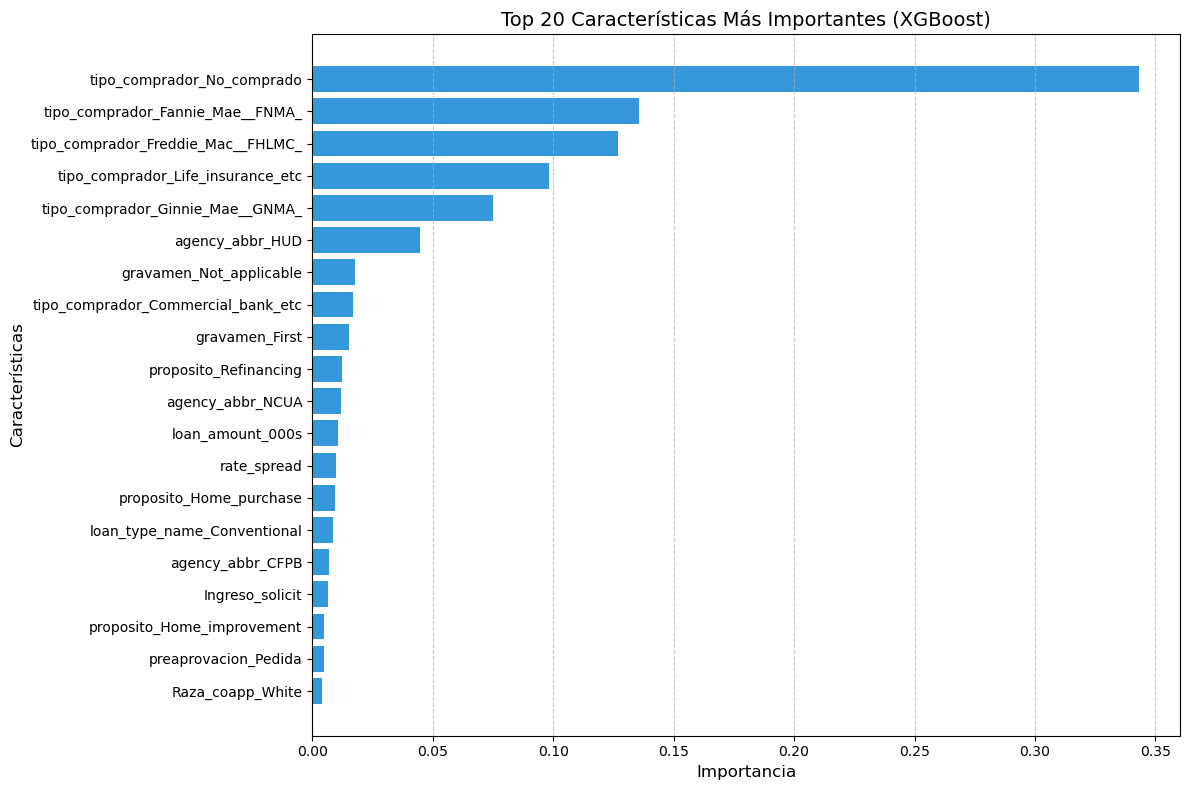

In [234]:
feature_importance = xg_final.feature_importances_
sorted_idx = np.argsort(feature_importance)  # Orden ascendente

# Tomar solo las top N características (ej. top 20, pq con todas no se ve nain)
top_20 = 20
top20_idx = sorted_idx[-top_20:]  # Índices de las top N
top20_features = X_train.columns[top20_idx]
top20_importance = feature_importance[top20_idx]

# Configurar el gráfico
plt.figure(figsize=(12, 8))
plt.barh(top20_features, top20_importance, color='#3498db')
plt.title(f'Top {top_20} Características Más Importantes (XGBoost)', fontsize=14)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Características', fontsize=12)
# plt.gca().invert_yaxis()  # Mostrar la más importante arriba
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

### 4.2.Shap values

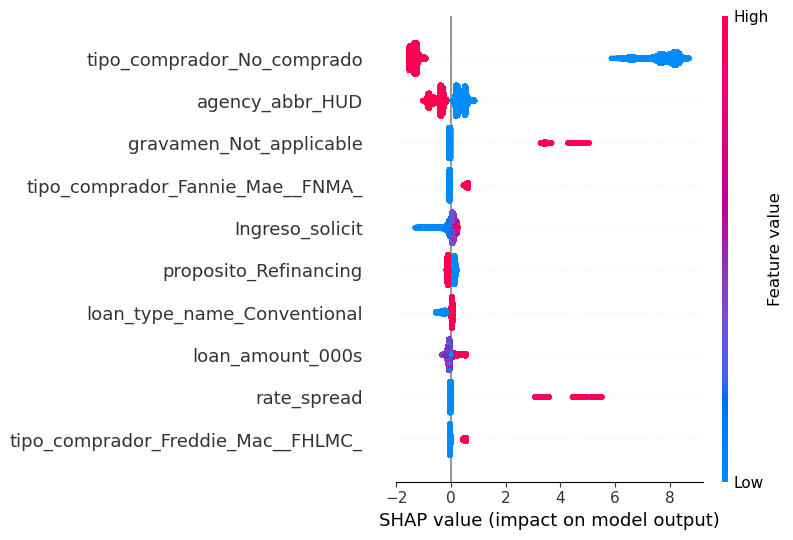

In [87]:
import shap

explainer = shap.TreeExplainer(xg_final)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="dot", max_display=10)


### 4.3.Plot individual

Muestra cómo se construye la predicción final $f(x)$ desde la media o esperanza base $E(f(x))$

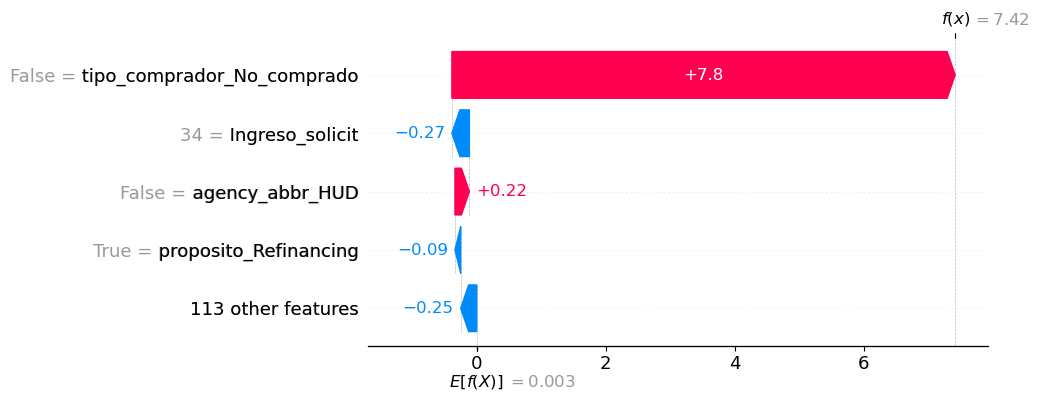

In [95]:
individual=84758
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[individual],
        base_values=explainer.expected_value,
        data=X_train.iloc[individual],
        feature_names=X_train.columns.tolist()
    ),
    max_display=5
)

## 5.Elaboración de perfiles y personalización de ofertas

### 5.1.Perfil ideal y perfil crítico

In [221]:
import pprint

# ——————————————————————————
# Sección 3 completa corregida
# ——————————————————————————

# 0) Clonar X_train para no modificar el original
X_train = X_train.copy()
# 1) Identificar las columnas usadas en el entrenamiento
columnas_modelo = xg_final.get_booster().feature_names

# 2) Preparar X_pred con solo esas columnas y añadir y_hat
X_pred = X_train[columnas_modelo]
X_train["y_hat"] = xg_final.predict_proba(X_pred)[:, 1]  # prob. de aprobado

# 3) Variables numéricas de interés
COL_PRESTAMO    = 'loan_amount_000s'
COL_INGRESO     = 'Ingreso_solicit'
COL_DEUDA_RATIO = 'deuda_ratio_calculada'

# 4) Recalcular deuda_ratio_calculada (DTI) si no existía
X_train[COL_DEUDA_RATIO] = (
    X_train[COL_PRESTAMO] * 1000
) / (
    X_train[COL_INGRESO] * 1000 + 1e-6
)

# 5) Función para calcular perfiles ideal y crítico
def calcular_perfiles(df):
    return {
        'ideal': {
            COL_INGRESO:     df[COL_INGRESO].quantile(0.90),
            COL_PRESTAMO:    df[COL_PRESTAMO].quantile(0.10),
            COL_DEUDA_RATIO: df[COL_DEUDA_RATIO].quantile(0.10)
        },
        'critico': {
            COL_INGRESO:     df[COL_INGRESO].quantile(0.10),
            COL_PRESTAMO:    df[COL_PRESTAMO].quantile(0.90),
            COL_DEUDA_RATIO: df[COL_DEUDA_RATIO].quantile(0.90)
        }
    }

perfiles = calcular_perfiles(X_train)

# 6) Función para mejores/peores categorías de variables dummy
def mejores_categorias(df, prefix):
    cols = [c for c in df.columns if c.startswith(prefix)]
    if not cols:
        return None, None
    # Calcula media de y_hat por categoria dummy
    medias = {col: df.loc[df[col]==1, 'y_hat'].mean() for col in cols}
    ideal = max(medias, key=medias.get)
    critico = min(medias, key=medias.get)
    return ideal, critico

# 7) Prefijos de columnas dummy en tu dataset
categoricals = [
    "tipo_comprador_",
    "tipo_propiedad_",
    "preaprobacion_",
    "tipo_ocupacion_",
    "msamd_name_",
    "loan_type_name_",
    "proposito_",
    "gravamen_",
    "hoepa_",
    "edit_status_name_",
    "condado_",
    "Sexo_",
    "Raza_",
    "Etnia_",
    "agency_abbr_"
]

# 8) Extender los perfiles con las categorías
perfiles_ext = {'ideal': perfiles['ideal'].copy(), 'critico': perfiles['critico'].copy()}
for prefix in categoricals:
    ideal_cat, crit_cat = mejores_categorias(X_train, prefix)
    if ideal_cat:
        perfiles_ext['ideal'][prefix[:-1]] = ideal_cat  # quita '_' final
    if crit_cat:
        perfiles_ext['critico'][prefix[:-1]] = crit_cat



# 1. Convertir a DataFrame
df_perfiles = pd.DataFrame({
    'Perfil Ideal': perfiles_ext['ideal'], 
    'Perfil Crítico': perfiles_ext['critico']
})

# 2. Opcional: formatear montos y decimales
df_perfiles['Perfil Ideal'] = df_perfiles['Perfil Ideal'].apply(
    lambda x: f"${int(x*1000):,}" if 'loan_amount_000s' in df_perfiles.index[df_perfiles['Perfil Ideal']==x][0]
    else (f"{x:.2f}" if isinstance(x, float) else x)
)
df_perfiles['Perfil Crítico'] = df_perfiles['Perfil Crítico'].apply(
    lambda x: f"${int(x*1000):,}" if 'loan_amount_000s' in df_perfiles.index[df_perfiles['Perfil Crítico']==x][0]
    else (f"{x:.2f}" if isinstance(x, float) else x)
)

# 3. Mostrar la tabla
print('-'*106)
print(df_perfiles.to_markdown())
print('-'*106)

----------------------------------------------------------------------------------------------------------
|                       | Perfil Ideal                               | Perfil Crítico                      |
|:----------------------|:-------------------------------------------|:------------------------------------|
| Ingreso_solicit       | 198.00                                     | 43.00                               |
| loan_amount_000s      | $114,000                                   | $492,000                            |
| deuda_ratio_calculada | 1.23                                       | 4.91                                |
| tipo_comprador        | tipo_comprador_Fannie_Mae__FNMA_           | tipo_comprador_No_comprado          |
| tipo_propiedad        | tipo_propiedad_1_4_fam_dwelling            | tipo_propiedad_Manufactured_housing |
| tipo_ocupacion        | tipo_ocupacion_Ocupada                     | tipo_ocupacion_Not_applicable       |
| msamd_name         

### 5.2.Segmentación de clientes y personalización de ofertas

In [236]:
#Creamos la variable dti que aproxima el ratio deuda ingreso y es como un indicador de riesgo
X_train['dti'] = (
    (X_train["loan_amount_000s" ] * 1000) /          # Monto del préstamo en miles
    (X_train["Ingreso_solicit"] * 1000 + 1e-6)  # Ingreso en USD (+1e-6 evita división por 0)
) * 100  # Convertir a porcentaje

#Según los resultados obtenidos en el top 20 caract de xgboost y en el shap, priorizamos estas variables
FEATURES_CLUSTERING = [
    "Ingreso_solicit",        # Ingreso del solicitante
    'loan_amount_000s',             # Monto del préstamo
    'dti',         # Ratio deuda/ingreso (calculado)
    'rate_spread',                  # Diferencial de tasa
    'loan_type_name_Conventional',  # Tipo de préstamo (dummy)
    'tipo_comprador_No_comprado',   # Comprado por agencia (dummy)
    'proposito_Refinancing',        # Propósito del préstamo (dummy)
    'agency_abbr_HUD',               # Agencia involucrada (dummy)
    'gravamen_Not_applicable'
]

In [238]:
from sklearn.preprocessing import StandardScaler

# 1. Escalar variables numéricas
scaler = StandardScaler()
X_cluster_num = scaler.fit_transform(X_train[FEATURES_CLUSTERING[:4]])

# 2. Combinar con variables dummy (ya están en 0-1)
X_cluster = np.hstack([X_cluster_num, X_train[FEATURES_CLUSTERING[4:]]])

In [240]:
#Clustering con k-means + análisis de riesgo

from sklearn.cluster import KMeans
import plotly.express as px

# 1. Crear 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
X_train['cluster'] = kmeans.fit_predict(X_cluster)

# 2. Analizar características por cluster
cluster_profile = X_train.groupby('cluster')[FEATURES_CLUSTERING].mean()
cluster_profile['tasa_aprobacion'] = X_train.groupby('cluster')['y_hat'].mean()

In [242]:
X_train["y_hat"] = xg_final.predict_proba(X_train[columnas_modelo])[:, 1]

bins = [0, 0.2, 0.5, 0.8, 1]
labels = ["Riesgo Crítico", "Alto Riesgo", "Riesgo Moderado", "Bajo Riesgo"]

# Calcular y_hat en TEST (datos no vistos)
X_test["y_hat"] = xg_final.predict_proba(X_test[columnas_modelo])[:, 1]

# Crear segmentos
X_test["segmento"] = pd.cut(
    X_test["y_hat"], 
    bins=bins, 
    labels=labels
)

# Asignar ofertas
ofertas = {
    "Riesgo Crítico": "Oportunidad de Mejora",
    "Alto Riesgo": "Reconstrucción Crediticia",
    "Riesgo Moderado": "Préstamo Seguro",
    "Bajo Riesgo": "Préstamo Premium"
}

X_test["oferta"] = X_test["segmento"].map(ofertas)

In [244]:
X_test["OFERTA RECOMENDADA"] = X_test["oferta"]
X_test["TASA DE APROBACIÓN"] = X_test['y_hat']
X_test["RIESGO"] = X_test["segmento"]

In [246]:
X_test[["TASA DE APROBACIÓN","RIESGO","OFERTA RECOMENDADA"]]

,TASA DE APROBACIÓN,RIESGO,OFERTA RECOMENDADA
413479,0.254912,Alto Riesgo,Reconstrucción Crediticia
30266,0.999568,Bajo Riesgo,Préstamo Premium
345161,0.048028,Riesgo Crítico,Oportunidad de Mejora
192795,0.999535,Bajo Riesgo,Préstamo Premium
87558,0.999672,Bajo Riesgo,Préstamo Premium
...,...,...,...
332903,0.015840,Riesgo Crítico,Oportunidad de Mejora
283980,0.178326,Riesgo Crítico,Oportunidad de Mejora
352415,0.054953,Riesgo Crítico,Oportunidad de Mejora
193398,0.999753,Bajo Riesgo,Préstamo Premium
